In [59]:
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
# put parent dir in path
sys.path.insert(0,'..')

In [92]:
# get exp num
while True:
    try:
        exp_num = int(input())
        break
    except ValueError:
        print("Must be an integer")

metrics_path = os.path.join("..", "model_metrics", "exp" + str(exp_num))

15


# Train and Test Metrics

In [16]:
def reindex_thresh(tpr, fpr, thresh):
    # get thresh to reindex by
    thresh_lens = np.array([i.shape[0] for i in thresh])
    rein_thresh = thresh[np.argmax(thresh_lens)]

    # reindex all these values so we are using the same thresholds
    for i in range(thresh.shape[0]):
        df = pd.DataFrame(columns=['fpr', 'tpr', 'thresh'])
        df['fpr'] = fpr[i]
        df['tpr'] = tpr[i]
        df['thresh'] = thresh[i]

        df = df.set_index('thresh').reindex(index=rein_thresh, method='nearest').reset_index()
        fpr[i] = df['fpr'][:, None]
        tpr[i] = df['tpr'][:, None]
        thresh[i] = df['thresh'][:, None]

    fpr = np.hstack(fpr).T
    tpr = np.hstack(tpr).T
    thresh = np.hstack(thresh).T
    
    return tpr, fpr, thresh

def get_theta_star(tpr, fpr, thresh, num_experiments):
    # get theta*
    best_thresh_inds = np.argmax(np.square(tpr) + np.square(1 - fpr), axis=1)
    best_threshs = thresh[np.arange(num_experiments), best_thresh_inds]
    
    return best_threshs, best_thresh_inds

def get_best_sens_spec(tpr, fpr, best_thresh_inds, num_experiments):
    # get sens/spec
    sens = 1 - fpr[np.arange(num_experiments), best_thresh_inds]
    spec = tpr[np.arange(num_experiments), best_thresh_inds]
    
    return sens, spec

def plot_metrics(data_to_plot):
    title = 'Train and Test Metrics'
    # Create a figure instance
    fig1 = plt.figure()
    # Create an axes instance
    ax = fig1.add_subplot(111)
    # Create the boxplot
    bp = ax.boxplot(data_to_plot)
    plt.title(title)
    ax.set_xticklabels(['Train Score','Test Score', 
                        'Train AUC', 'Test AUC',
                        'Train Spec', 'Test Spec',
                        'Train Sens', 'Test Sens'])
    plt.xticks(rotation=45)
    plt.show(fig1)

def plot_theta_star(theta_data):
    title = 'Train and Test Best Threshold'
    # Create a figure instance
    fig1 = plt.figure()
    # Create an axes instance
    ax = fig1.add_subplot(111)
    # Create the boxplot
    bp = ax.boxplot(theta_data)
    plt.title(title)
    ax.set_xticklabels(['Best Train Thresh', 'Best Test Thresh'])
    plt.xticks(rotation=45)
    plt.show(fig1)    


def plot_all(data_to_plot, theta_data):
    title = 'Train and Test Metrics'
    # Create a figure instance
    fig1 = plt.figure(figsize=(10,2))
    # Create an axes instance
    ax = fig1.add_subplot(121)
    # Create the boxplot
    bp = ax.boxplot(data_to_plot)
    plt.title(title)
    ax.set_xticklabels(['Train Score','Test Score', 
                        'Train AUC', 'Test AUC',
                        'Train Spec', 'Test Spec',
                        'Train Sens', 'Test Sens'])
    plt.xticks(rotation=45)
    
    title = 'Train and Test Best Threshold'
    # Create an axes instance
    ax = fig1.add_subplot(122)
    # Create the boxplot
    bp = ax.boxplot(theta_data)
    plt.title(title)
    ax.set_xticklabels(['Best Train Thresh', 'Best Test Thresh'])
    plt.xticks(rotation=45)
    plt.show(fig1)  


def plot_roc(train, tpr, fpr, auc):
    avg_auc = np.average(auc)
    if train:
        title = 'Train ROC'
    else:
        title = 'Test ROC'
    avg_tpr = np.average(tpr, axis=0)
    avg_fpr = np.average(fpr, axis=0)
    tpr_std = np.std(tpr, axis=0)
    fpr_std = np.std(fpr, axis=0)
    for i in range(tpr.shape[0]):
        plt.plot(fpr[i], tpr[i], 'b', linewidth=0.5)
    plt.title(title)
    plt.figtext(0.45, 0.15,'Average AUC: ' + str(avg_auc))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.plot(avg_fpr, avg_tpr, 'r')
    plt.plot(np.add(avg_fpr, fpr_std), np.add(avg_tpr, tpr_std), 'k')
    plt.plot(np.add(avg_fpr, -1*fpr_std), np.add(avg_tpr, -1*tpr_std), 'k')
    plt.show()

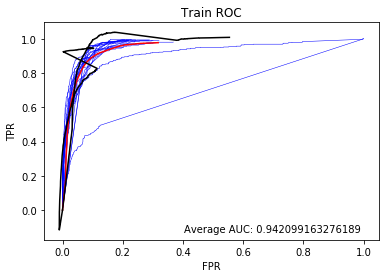

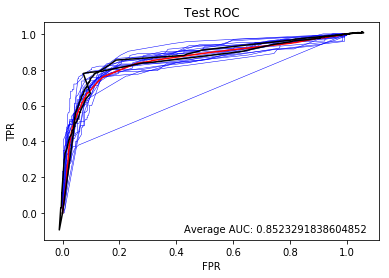

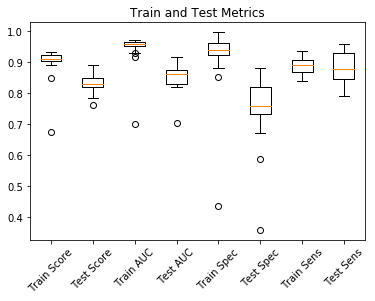

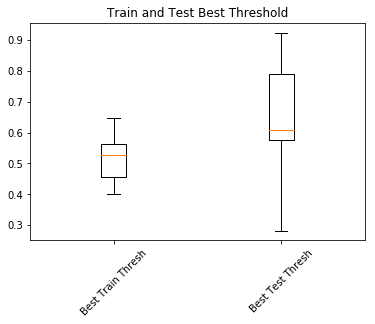

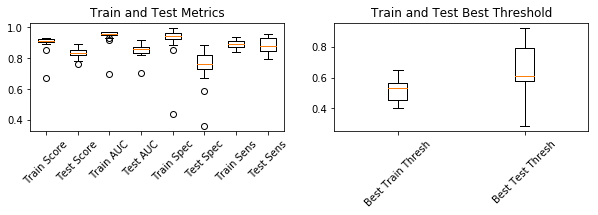

In [17]:
num_experiments = 20
metric_data_to_plot = {'train':[], 'test':[]}
theta_data = []
for t in ['train', 'test']:
    scores = np.load(os.path.join(metrics_path, t+"_scores.npy"), allow_pickle=True)
    scores = [i[0] for i in scores]
    auc = np.load(os.path.join(metrics_path, t+"_auc_all.npy"), allow_pickle=True)
    auc = [i[0] for i in auc]
    fpr = np.load(os.path.join(metrics_path, t+"_fpr_all.npy"), allow_pickle=True)
    tpr = np.load(os.path.join(metrics_path, t+"_tpr_all.npy"), allow_pickle=True)
    thresh = np.load(os.path.join(metrics_path, t+"_thresholds_all.npy"), allow_pickle=True)
    tpr_reindexed, fpr_reindexed, thresh_reindexed = reindex_thresh(tpr, fpr, thresh)
    best_threshs, best_thresh_inds = get_theta_star(tpr_reindexed, fpr_reindexed, thresh_reindexed, num_experiments)
    sens, spec = get_best_sens_spec(tpr_reindexed, fpr_reindexed, best_thresh_inds, num_experiments)
    train = t == 'train'
    plot_roc(train, tpr_reindexed, fpr_reindexed, auc)
    metric_data_to_plot[t].append(scores)
    metric_data_to_plot[t].append(auc)
    metric_data_to_plot[t].append(spec)
    metric_data_to_plot[t].append(sens)
    theta_data.append(best_threshs)

# Re-ordering vectors so same data type is adjacent for train and test
final_metric_data = []
for i in range(len(metric_data_to_plot['train'])):
    final_metric_data.append(list(metric_data_to_plot['train'][i]))
    final_metric_data.append(list(metric_data_to_plot['test'][i]))

plot_metrics(final_metric_data)
plot_theta_star(theta_data)
plot_all(final_metric_data, theta_data)

In [109]:
def old_plot_coefficients(exp_num, max_num):
    coef = np.load('../model_metrics/exp'+str(exp_num)+'/coefficients.npy')
#     print(coef.shape)
    mean_coef = np.mean(coef, axis=1)
    abs_coef = np.absolute(mean_coef)

    # Taking top and bottom 10 (most positive and most negative)
    sorted_idcs = np.argsort(abs_coef)

    selected_idcs = sorted_idcs[-10:]
    selected_means = mean_coef[selected_idcs]

    # Getting selected indices from the coefficient matrix
    selected_coef = coef[selected_idcs, :]
#     print(selected_coef.shape)

    title = 'Coefficients Having Largest Absolute Value'
    # Create a figure instance
    fig1 = plt.figure()
    # Create an axes instance
    ax = fig1.add_subplot(111)
    # Create the boxplot
    bp = ax.boxplot(selected_coef.T)
    plt.title(title)
    plt.xlabel('Feature Index')
    plt.ylabel('Coefficient Value')
    ax.set_xticklabels(selected_idcs)
    # plt.xticks(rotation=45)
    plt.show(fig1)    


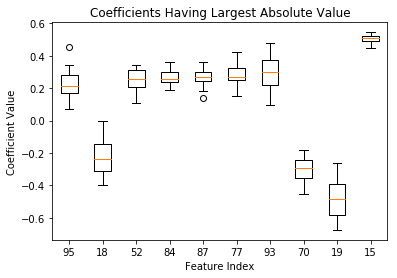

In [110]:
# Plotting coefficients of top n features with highest average coefficients
max_num = 10
old_plot_coefficients(exp_num, max_num)


In [89]:
test_array = np.load('../model_metrics/exp15/coefficients.npy')
print(test_array)
coef_df = pd.read_csv('../model_metrics/exp15/coefficients.csv')
display(coef_df)
feat_names = list(coef_df['Unnamed: 0'])
print(feat_names)
coef_df_vals = coef_df.drop(columns=['Unnamed: 0'])
coefficients = coef_df_vals.values
print(coefficients)
print(coefficients.shape)

[[-0.01198119  0.00453552 -0.04091034 ... -0.0305085   0.00458837
   0.        ]
 [ 0.06447896  0.0754645   0.10976511 ...  0.04499319  0.07881135
   0.07266215]
 [ 0.04061558 -0.04379604  0.1605487  ... -0.11927679  0.076065
  -0.06171743]
 ...
 [ 0.21631549  0.26978197  0.15166588 ...  0.20905526  0.07148078
   0.0748162 ]
 [-0.20766406 -0.40241717 -0.08212545 ... -0.05777135 -0.1742883
  -0.3369514 ]
 [ 0.15713524  0.26581811  0.         ...  0.07067545  0.07449597
   0.44406403]]


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,hr_pca0,-0.011981,0.004536,-0.040910,0.018399,-0.038311,-0.022003,-0.012844,-0.030198,-0.017488,...,-0.012759,-0.010345,0.027311,0.010589,-0.002122,0.019012,-0.021119,-0.030508,0.004588,0.000000
1,hr_pca1,0.064479,0.075464,0.109765,0.042266,0.059920,0.000000,0.124352,0.065263,0.021396,...,0.047265,0.000131,-0.016627,0.002784,0.030097,0.027406,0.001507,0.044993,0.078811,0.072662
2,hr_pca2,0.040616,-0.043796,0.160549,0.025416,0.036628,-0.124669,0.000000,-0.028974,0.063959,...,0.067784,0.025190,0.000000,-0.025989,-0.074610,0.059694,0.013207,-0.119277,0.076065,-0.061717
3,hr_pca3,0.065459,-0.057193,-0.068066,-0.098938,-0.187190,-0.172331,-0.063526,0.010269,0.049007,...,-0.070227,0.058359,0.000000,-0.167779,0.000000,0.078963,-0.093353,-0.047289,-0.155258,0.000000
4,hr_pca4,-0.184428,-0.203637,-0.498886,-0.484276,-0.153600,0.355519,-0.112442,-0.287973,-0.359897,...,-0.289332,-0.198789,-0.191266,-0.197816,-0.166705,-0.353953,-0.285040,-0.216840,-0.266174,0.104309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,eyes,0.146589,0.330943,0.477000,0.387596,0.311239,0.222753,0.221382,0.296155,0.213377,...,0.093637,0.300675,0.148011,0.395099,0.374280,0.370308,0.291873,0.231884,0.317726,0.227429
94,temp,0.000000,0.013701,0.000000,0.008763,0.000000,-0.107065,-0.001267,0.215498,0.000000,...,-0.066443,0.152198,0.325726,-0.017607,0.077299,0.186252,0.000811,0.023464,-0.043734,0.135766
95,sys,0.216315,0.269782,0.151666,0.271805,0.201132,0.215627,0.192974,0.165988,0.171460,...,0.337827,0.138625,0.307036,0.223287,0.239632,0.451043,0.324782,0.209055,0.071481,0.074816
96,dias,-0.207664,-0.402417,-0.082125,-0.221461,-0.101501,0.000000,-0.269621,-0.197504,-0.116673,...,-0.239306,-0.318818,-0.145292,-0.123788,-0.073094,-0.383463,-0.211486,-0.057771,-0.174288,-0.336951


['hr_pca0', 'hr_pca1', 'hr_pca2', 'hr_pca3', 'hr_pca4', 'resp_pca0', 'resp_pca1', 'resp_pca2', 'resp_pca3', 'resp_pca4', 'sao2_pca0', 'sao2_pca1', 'sao2_pca2', 'sao2_pca3', 'sao2_pca4', 'gcs_pca0', 'gcs_pca1', 'gcs_pca2', 'gcs_pca3', 'gcs_pca4', '-basos', '-eos', '-lymphs', '-monos', '-polys', 'ALT (SGPT)', 'AST (SGOT)', 'BUN', 'Base Excess', 'FiO2', 'HCO3', 'Hct', 'Hgb', 'MCH', 'MCHC', 'MCV', 'MPV', 'O2 Sat (%)', 'PT', 'PT - INR', 'PTT', 'RBC', 'RDW', 'WBC x 1000', 'albumin', 'alkaline phos.', 'anion gap', 'bedside glucose', 'bicarbonate', 'calcium', 'chloride', 'creatinine', 'glucose', 'magnesium', 'pH', 'paCO2', 'paO2', 'phosphate', 'platelets x 1000', 'potassium', 'sodium', 'total bilirubin', 'total protein', '0', '2', '5', '14', '19', '36', '38', '41', '44', '56', '59', '65', '71', '80', '83', '92', '95', '99', 'fentanyl', 'insulin', 'midazolam', 'morphine', 'nicardipine', 'norepinephrine', 'phenylephrine', 'propofol', 'redbloodcell', 'sodium', 'vasopressin', 'verbal', 'eyes', 'te

In [105]:
def plot_coefficients(exp_num, max_num):
    coef_df = pd.read_csv('../model_metrics/exp'+str(exp_num)+'/coefficients.csv')
    feat_names = list(coef_df['Unnamed: 0'])
    coef_df_vals = coef_df.drop(columns=['Unnamed: 0'])
    coef = coef_df_vals.values
    mean_coef = np.mean(coef, axis=1)
    abs_coef = np.absolute(mean_coef)

    # Taking top and bottom 10 (most positive and most negative)
    sorted_idcs = np.argsort(abs_coef)

    selected_idcs = sorted_idcs[-10:]
    selected_means = mean_coef[selected_idcs]


    # Getting selected indices from the coefficient matrix
    selected_coef = coef[selected_idcs, :]
    # Getting selected feature names
    selected_feat = [feat_names[i] for i in selected_idcs]

    title = 'Coefficients Having Largest Absolute Value'
    # Create a figure instance
    fig1 = plt.figure()
    # Create an axes instance
    ax = fig1.add_subplot(111)
    # Create the boxplot
    bp = ax.boxplot(selected_coef.T)
    plt.title(title)
    plt.xlabel('Feature Index')
    plt.ylabel('Coefficient Value')
    ax.set_xticklabels(selected_feat)
    plt.xticks(rotation=70)
    plt.show(fig1)    

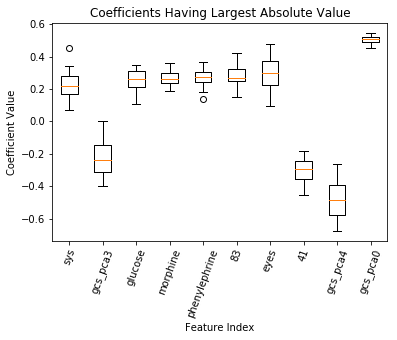

In [106]:
# Plotting coefficients of top n features with highest average coefficients
max_num = 10
plot_coefficients(exp_num, max_num)